In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
# comment this line if you want to run on GPU. 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # -> exec on CPU

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sciann as sn

2021-12-21 22:49:41.850836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 22:49:41.850864: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---------------------- SCIANN 0.6.5.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.2 
Python Version: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0] 



In [5]:
from pathlib import Path
from turboflow.datasets.turb2D import Turb2D

time_idx = 256

def prepare_data(ds, num_data=64*64, random=True):

    data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
    tb = Turb2D(data_dir)
    tb.load_data(time_idx)
    
    xy = tb.xy # R x R x 2
    uv = tb.uv # R x R x 2
        
    uv = uv/np.max(np.abs(uv))
    assert np.min(uv) >= -1
    assert np.max(uv) <=  1
    
    XX = xy[::ds, ::ds, 0] # R x R
    YY = xy[::ds, ::ds, 1] # R x R
    UU = uv[::ds, ::ds, 0] # R x R
    VV = uv[::ds, ::ds, 1] # R x R
        
    R = XX.shape[0]
    N = R*R

    # Pick random data.
    if random:
        idx = np.random.choice(N, num_data, replace=False)
    else:
        idx = np.arange(0, N)
    
    x = XX.flatten()[idx,None] # RR x 1
    y = YY.flatten()[idx,None] # RR x 1
    
    u = UU.flatten()[idx,None] # RR x 1
    v = VV.flatten()[idx,None] # RR x 1
    
    return (x, y, u, v)

x_train, y_train, u_train, v_train = prepare_data(8, random=False)
print(x_train.shape)
x_test, y_test, u_test, v_test = prepare_data(1, random=False)
print(x_test.shape)

(1024, 1)
(65536, 1)


In [28]:
x = sn.Variable('x', dtype='float64')
y = sn.Variable('y', dtype='float64')
xy = sn.Functional('xy', [x, y], hidden_layers=None, activation=None)

nrff = 256
B = 10*np.random.randn(2,nrff)
xyf = sn.fourier(xy, B)
xyf.set_trainable(False)

u = sn.Field('v', dtype='float64')
v = sn.Field('u', dtype='float64')

u, v = sn.Functional([u, v], [xyf], 8*[256], 'tanh')

d1 = sn.Data(u)
d2 = sn.Data(v)

u_x = sn.diff(u, x)
v_y = sn.diff(v, y)
c1 = sn.PDE(u_x + v_y)

In [29]:
model = sn.SciModel(
    inputs = [x, y],
    targets = [d1, d2, c1],
    loss_func= "mse",
    optimizer= "adam",
    plot_to_file='model.png',
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
concat_9 (Concatenate)          (None, 2)            0           x[0][0]                          
                                                                 y[0][0]                          
__________________________________________________________________________________________________
xy (Field)                      (None, 1)            3           concat_9[0][0]             

In [15]:
input_data = [x_train, y_train]
target_data = [u_train, v_train, 'zeros']

In [16]:
history = model.train(
    x_true=input_data,
    y_true=target_data,
    batch_size=1024,
    learning_rate=0.002,
    epochs=5000,
    verbose=0)


Total samples: 1024 
Batch size: 1024 
Total batches: 1 



KeyboardInterrupt: 

In [17]:
plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

NameError: name 'history' is not defined

In [18]:
print(history)

NameError: name 'history' is not defined

In [21]:
pred = model.predict([x_test, y_test])

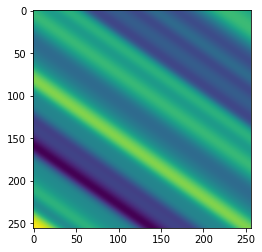

In [23]:
u_pred = pred[0]
plt.imshow(u_pred.reshape(256,256))
